# Imports

In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set()
import shap

# Utils

In [4]:
from sklearn.metrics import average_precision_score, log_loss

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def relative_cross_entropy_score(gt, pred):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

def compute_score(y_true, y_score):
    ap = average_precision_score(y_true, y_score)
    rce = relative_cross_entropy_score(y_true, y_score)
    return ap, rce

def pretty_evaluation(results):
    mAP = (
        results['retweet_AP']
        +results['reply_AP']
        +results['like_AP']
        +results['retweet_with_comment_AP']
    ) / 4
    mRCE = (
        results['retweet_RCE']
        +results['reply_RCE']
        +results['like_RCE']
        +results['retweet_with_comment_RCE']
    ) / 4
    return f"""
---------------------------------
AP Retweet:                {results['retweet_AP']:.4f}
RCE Retweet:               {results['retweet_RCE']:.4f}
---------------------------------
AP Reply:                  {results['reply_AP']:.4f}
RCE Reply:                 {results['reply_RCE']:.4f}
---------------------------------
AP Like:                   {results['like_AP']:.4f}
RCE Like:                  {results['like_RCE']:.4f}
---------------------------------
AP RT with comment:        {results['retweet_with_comment_AP']:.4f}
RCE RT with comment:       {results['retweet_with_comment_RCE']:.4f}

---------------------------------

mAP                        {mAP:.4f}
mRCE                       {mRCE:.4f}

""".strip()

def just_mAP_mRCE(results):
    mAP = (
        results['retweet_AP']
        +results['reply_AP']
        +results['like_AP']
        +results['retweet_with_comment_AP']
    ) / 4
    mRCE = (
        results['retweet_RCE']
        +results['reply_RCE']
        +results['like_RCE']
        +results['retweet_with_comment_RCE']
    ) / 4
    return f"""
mAP                        {mAP:.4f}
mRCE                       {mRCE:.4f}

""".strip()

# Loading in data

In [10]:
df[['reply_timestamp',
 'retweet_timestamp',
 'retweet_with_comment_timestamp',
 'like_timestamp']].dropna()

,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
68270,1.612835e+09,1.612836e+09,1.612836e+09,1.612835e+09
79986,1.613162e+09,1.613162e+09,1.613162e+09,1.613162e+09
106976,1.612444e+09,1.612444e+09,1.612444e+09,1.612444e+09
141065,1.613775e+09,1.613775e+09,1.613775e+09,1.613775e+09
190374,1.613235e+09,1.613235e+09,1.613235e+09,1.613235e+09


In [25]:
df[['reply_timestamp',
 'retweet_timestamp',
 'retweet_with_comment_timestamp',
 'like_timestamp']].min(axis=1)

0         1.613913e+09
1                  NaN
2         1.613321e+09
3                  NaN
4         1.614003e+09
              ...     
224094             NaN
224095             NaN
224096             NaN
224097             NaN
224098    1.613668e+09
Length: 224099, dtype: float64

In [5]:
features = [
    "text_tokens",
    "hashtags",
    "tweet_id",
    "present_media",
    "present_links",
    "present_domains",
    "tweet_type",
    "language",
    "tweet_timestamp",
    "engaged_with_user_id",
    "engaged_with_user_follower_count",
    "engaged_with_user_following_count",
    "engaged_with_user_is_verified",
    "engaged_with_user_account_creation",
    "engaging_user_id",
    "engaging_user_follower_count",
    "engaging_user_following_count",
    "engaging_user_is_verified",
    "engaging_user_account_creation",
    "engagee_follows_engager",
]

features_idx = dict(zip(features, range(len(features))))

labels_idx = {
    "reply_timestamp": 20,
    "retweet_timestamp": 21,
    "retweet_with_comment_timestamp": 22,
    "like_timestamp": 23,
}
names = features + list(labels_idx)

In [6]:
df = pd.read_csv('../data/raw/sample_200k_rows', names=names, sep='\x01')
df = df.assign(**{
    "reply": df["reply_timestamp"].notna(),
    "retweet": df["retweet_timestamp"].notna(),
    "retweet_with_comment": df["retweet_with_comment_timestamp"].notna(),
    "like": df["like_timestamp"].notna()
})
# .drop([
#     'reply_timestamp',
#     'retweet_timestamp',
#     'retweet_with_comment_timestamp',
#     'like_timestamp'
# ], axis=1)

In [5]:
df

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,...,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,reply,retweet,retweet_with_comment,like
0,101\t10289\t19348\t18519\t784\t59269\t16849\t1...,NaN,D798864A80C4B28B7A75B8E411C24728,NaN,NaN,NaN,Quote,9A78FC330083E72BE0DD1EA92656F3B5,1613912916,044FED4C9797C84D59C33585CF6EC690,...,23BA543F14A948322EF0C1FFB427B95E,50,335,False,1548003258,False,False,False,False,True
1,101\t56898\t137\t171\t20246\t168\t194\t46671\t...,NaN,3F3153D1EEE6C4B3C1546BA9997AC1D7,Photo,NaN,NaN,Retweet,E7F038DE3EAD397AEC9193686C911677,1613783112,999C0EEFEDB7E7C3585CC33EB0FE65DC,...,878823042871ED31863CEC35897C4C8B,38,638,False,1458890236,False,False,False,False,False
2,101\t14535\t189\t58768\t82856\t191\t10911\t113...,NaN,26DC4B642DA4DA97E469305A03D20829,NaN,NaN,NaN,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,1613290787,5F1CAD78B474A0F5888552ECD92A3DCC,...,2B5A00459DB471F959252170257CF7BF,404,178,False,1246210670,False,False,False,False,True
3,101\t150\t86888\t41275\t110909\t10738\t142\t39...,NaN,FB828E786FDDDEFB5827832967496B61,Photo,72D7397E286C3CD4BD41D0CF2C76A835,F595B7DE8992A3D8C7948B4E81419D78,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,1612471288,4273D91B4A3FA9464C2CFBA738D4080D,...,9AA9BA11BA81FC6514D6C7D98DD5C968,113,264,False,1292185341,False,False,False,False,False
4,101\t1919\t27843\t101955\t18226\t12230\t22396\...,NaN,ADC4085E3313C32E2F9151134FE37674,NaN,NaN,NaN,Quote,E7F038DE3EAD397AEC9193686C911677,1613998385,1A89120910A5DC201E746DFB2E43F773,...,45EBDA7B6562D7620E7609BA992C79DE,1123,1220,False,1529061495,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224094,101\t56898\t137\t74004\t83779\t168\t49409\t110...,NaN,9E85CCA16A556C2599F93FFA477C1C28,Video,NaN,NaN,Retweet,B8B04128918BBF54E2E178BFF1ABA833,1613245388,70566B1733BB045EFCAEBB9B8B372CF0,...,453E8BA01BBE378B2E730FFAA1E35C61,115,120,False,1580507486,False,False,False,False,False
224095,101\t97593\t24512\t761\t16498\t34414\t10461\t5...,NaN,7D52A1609D717EA16C7B7C35A5C9FC72,NaN,NaN,NaN,TopLevel,9A78FC330083E72BE0DD1EA92656F3B5,1612827555,B7EDB18056E3C2388D0BD8F062ADD649,...,3D551D8101AA6E88FE8887A8D8313278,67,212,False,1564593210,False,False,False,False,False
224096,101\t31301\t183\t119\t91327\t10107\t100\t108\t...,F6EBCDE6330715CA874FCB6A075F9ABA,6DC57A2E891088D7FACE14A59DBBA19F,NaN,NaN,NaN,Quote,488B32D24BD4BB44172EB981C1BCA6FA,1612531477,5D36A0CC44532FD3DAABC3636548A712,...,2B4960948518935DE0917FD737DF9EFB,32,312,False,1510873142,False,False,False,False,False
224097,101\t56898\t137\t13518\t11517\t11889\t50555\t1...,NaN,CA9B0D5A77F18111DF18BCCE1112E682,NaN,NaN,NaN,Retweet,9A78FC330083E72BE0DD1EA92656F3B5,1613128148,22132BE53D4E6224E7329F1D11656BFF,...,8B99D8F34E2E62A5F2C729579E63EA00,309,277,False,1503746706,True,False,False,False,False


# Trainining, Validation, Testing split and Feature Engineering

In [27]:
targets = ["reply", "retweet", "retweet_with_comment", "like"]

enabled_features = [
    # Tweet features
    "tweet_type",
    "language",
    "tweet_timestamp",
    # Engaged-with User (i.e., Engagee) Features
    "engaged_with_user_follower_count",
    "engaged_with_user_following_count",
    "engaged_with_user_is_verified",
    "engaged_with_user_account_creation",
    # Engaging User (i.e., Engager) Features
    "engaging_user_follower_count",
    "engaging_user_following_count",
    "engaging_user_is_verified",
    "engaging_user_account_creation",
    # Engagement features
    "engagee_follows_engager"
]

categorical_features = [
    'language',
    'tweet_type',
]

In [28]:
%%time
# Holdout split
df_train = df.iloc[0                 :int(len(df) * 0.6)]
df_valid = df.iloc[int(len(df) * 0.6):int(len(df) * 0.8)]
df_test = df.iloc [int(len(df) * 0.8):                  ]

# Feature Selection
df_train_features = df_train[enabled_features]
df_valid_features = df_valid[enabled_features]
df_test_features = df_test[enabled_features]

assert df_train_features.notna().all().all(), "no nulls in any column"

# Feature Engineering
## Target Encoding of categorical features

target_encoders = {}
for feature in categorical_features:
    for target in targets:
        te = ce.TargetEncoder(smoothing=20.0)
        te.fit(df_train[feature], df_train[target])
        target_encoders[f'TE_{feature}__{target}'] = te

for tmp_df in [df_train_features, df_valid_features, df_test_features]:
    for name, te in target_encoders.items():
        tmp_df[name] = te.transform(tmp_df[te.cols[0]])[te.cols[0]]

        
for col in categorical_features:
    df_train_features = df_train_features.drop(col, axis=1)
    df_valid_features = df_valid_features.drop(col, axis=1)
    df_test_features = df_test_features.drop(col, axis=1)

# Column size assertions
assert df_train_features.shape[1] == df_valid_features.shape[1] == df_test_features.shape[1], \
    "train, valid, test should have the same number of columns"

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

CPU times: user 739 ms, sys: 23 µs, total: 739 ms
Wall time: 754 ms


# Model Training and Evaluation

What the current top leaderboard submission looks like:
```
mAP:                        0.3115
mRCE:                      16.4698
```
Leaderboard: https://recsys-twitter.com/leaderboard/all-submissions

> TODO(Andrea): understand how to cross-validate

In [29]:
df_train_features

,tweet_timestamp,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,TE_language__reply,TE_language__retweet,TE_language__retweet_with_comment,TE_language__like,TE_tweet_type__reply,TE_tweet_type__retweet,TE_tweet_type__retweet_with_comment,TE_tweet_type__like
0,1613912916,1062,2498,False,1593549601,50,335,False,1548003258,False,0.061511,0.088166,0.007323,0.384886,0.033705,0.053526,0.004841,0.362258
1,1613783112,34662,281,False,1256004696,38,638,False,1458890236,False,0.026486,0.054819,0.003520,0.416956,0.005571,0.112763,0.006185,0.248039
2,1613290787,68605,1056,False,1488728385,404,178,False,1246210670,False,0.027695,0.079603,0.007743,0.386935,0.040863,0.077879,0.007833,0.483139
3,1612471288,28392,353,False,1549245787,113,264,False,1292185341,False,0.032736,0.073062,0.011102,0.419869,0.040863,0.077879,0.007833,0.483139
4,1613998385,4490,27,False,1580081977,1123,1220,False,1529061495,False,0.026486,0.054819,0.003520,0.416956,0.033705,0.053526,0.004841,0.362258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134454,1613122944,14288,13860,False,1441602051,1185,1549,False,1558350781,True,0.026486,0.054819,0.003520,0.416956,0.040863,0.077879,0.007833,0.483139
134455,1613253986,453,404,False,1513387085,452,566,False,1421096937,True,0.032736,0.073062,0.011102,0.419869,0.040863,0.077879,0.007833,0.483139
134456,1613680088,232387,16,False,1422910513,12,93,False,1606191663,False,0.027695,0.079603,0.007743,0.386935,0.033705,0.053526,0.004841,0.362258
134457,1613391470,5594,493,False,1302347011,688,264,False,1464642092,False,0.027695,0.079603,0.007743,0.386935,0.040863,0.077879,0.007833,0.483139


In [30]:
%%time
# Training and Evaluation

dtest = xgb.DMatrix(df_test_features)
results = {}
models = {}
for target in targets:
    dtrain = xgb.DMatrix(df_train_features, df_train[target])
    dvalid = xgb.DMatrix(df_valid_features, df_valid[target])
    models[target] = model = xgb.train(params={
        'tree_method': 'gpu_hist',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        },
        evals=[(dvalid, "validation")],
        early_stopping_rounds=10,
        dtrain=dtrain,
        num_boost_round=50,
        verbose_eval=False,
    )
    AP, RCE = compute_score(df_test[target], model.predict(dtest))
    results[f"{target}_AP"] = AP
    results[f"{target}_RCE"] = RCE

print(just_mAP_mRCE(results))

mAP                        0.2176
mRCE                       6.2876
CPU times: user 3.44 s, sys: 147 ms, total: 3.58 s
Wall time: 3.35 s


# Model analysis

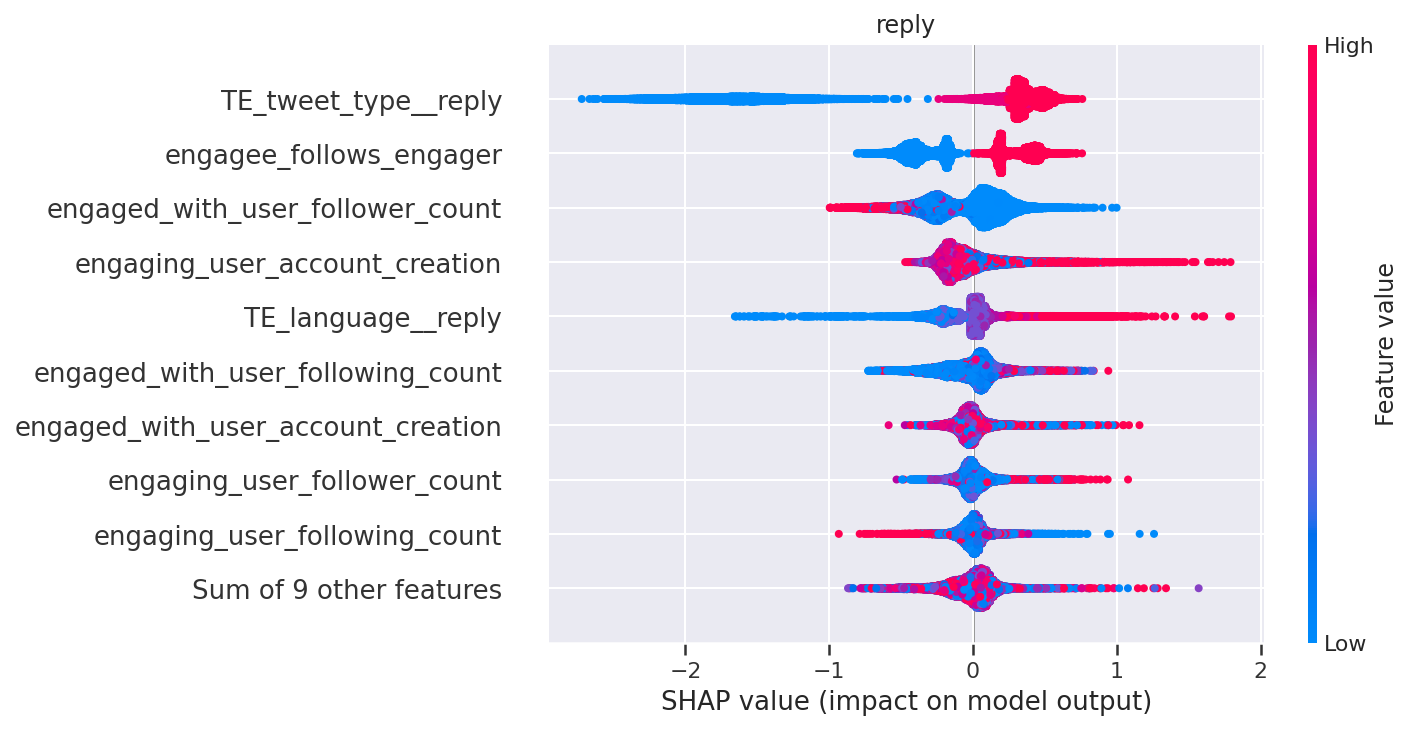

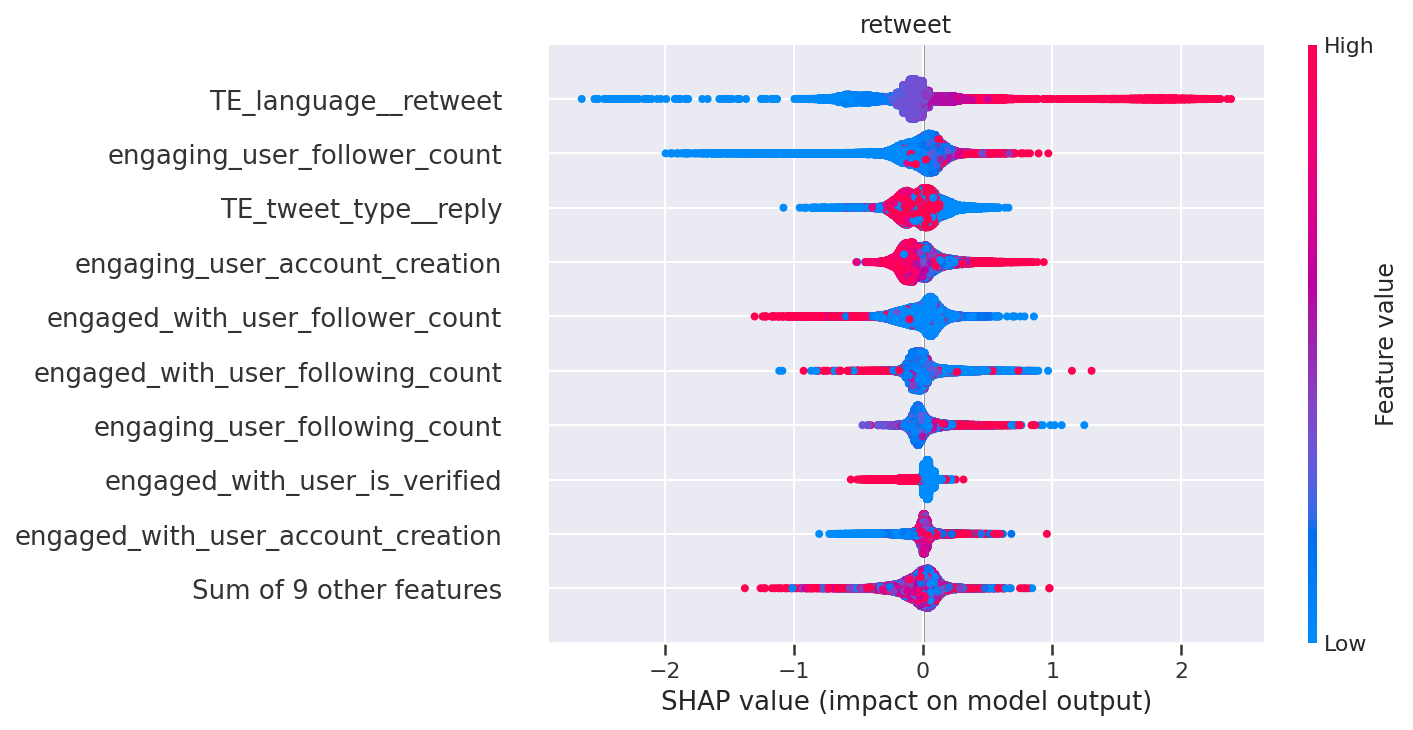

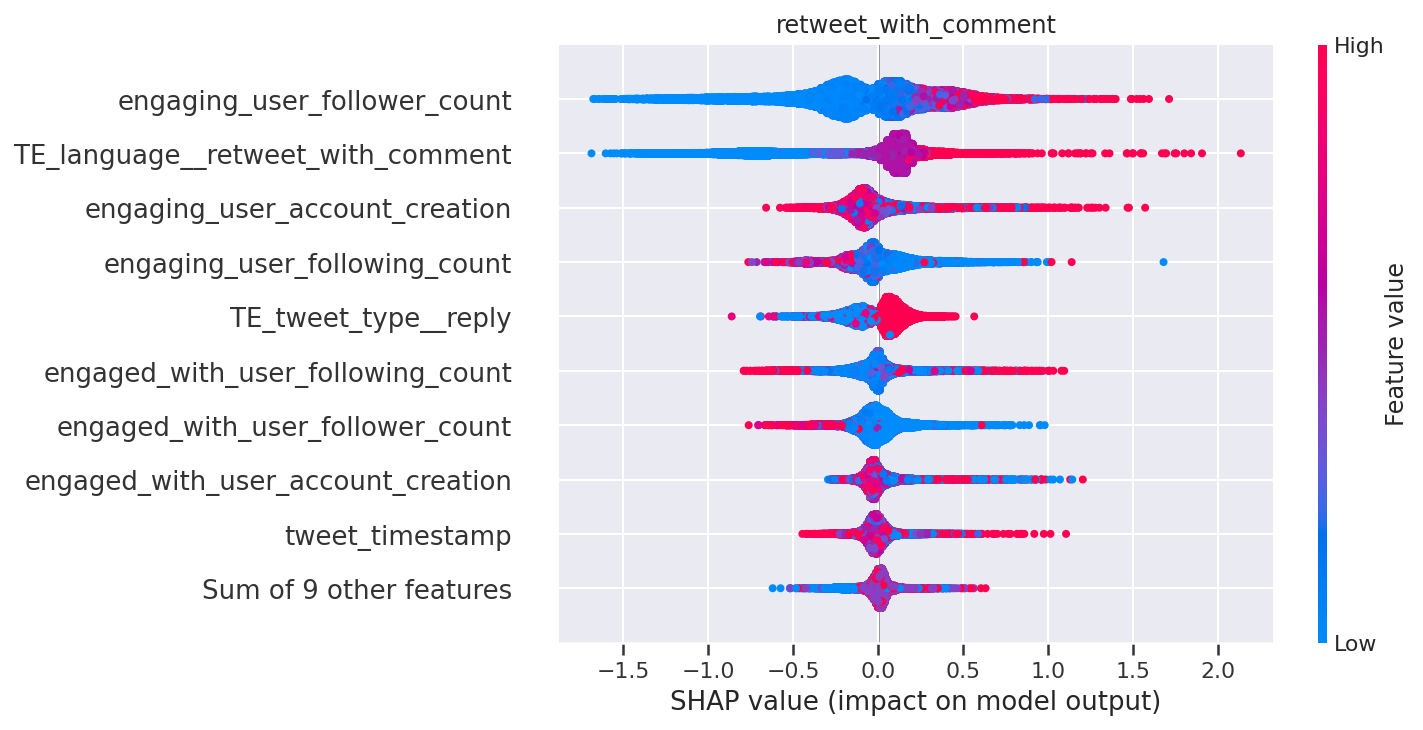

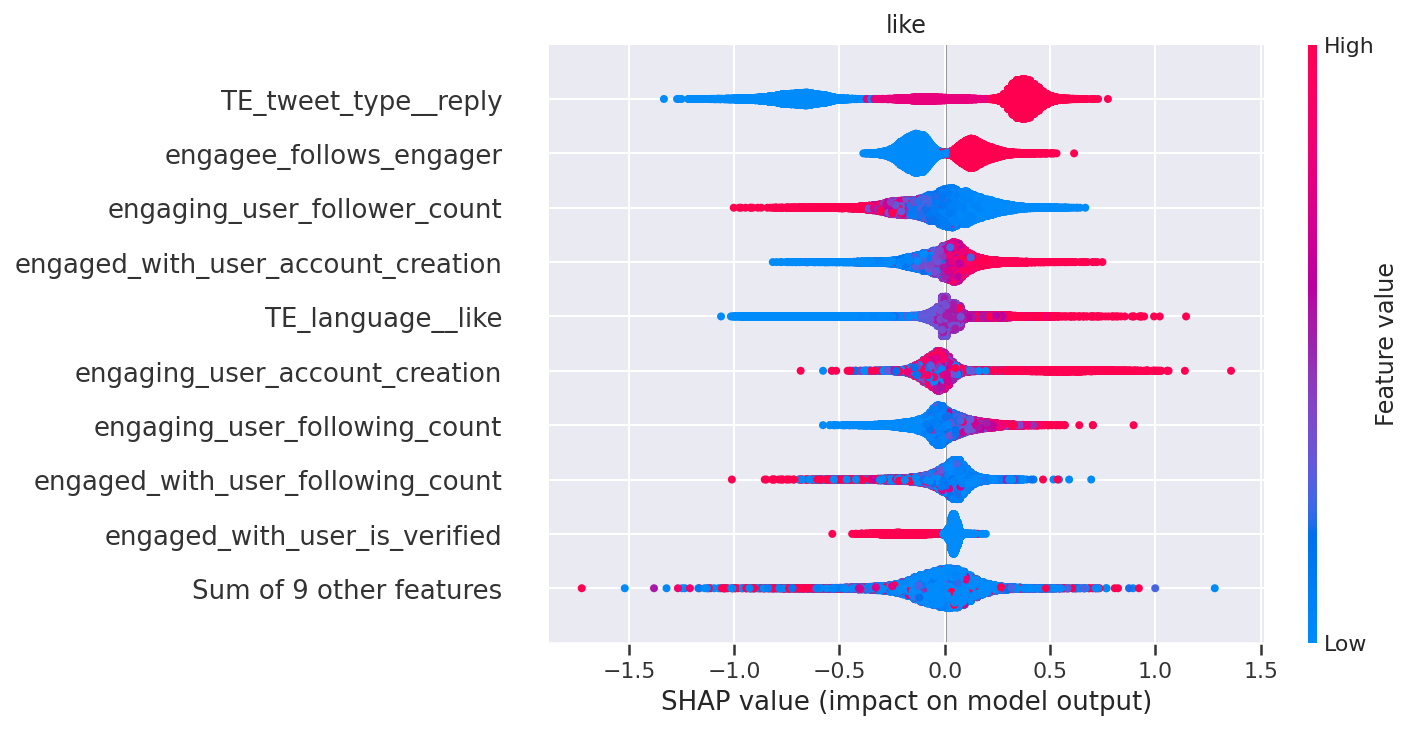

In [10]:
for target, model in models.items():
    plt.title(target)
    shap.plots.beeswarm(shap.Explainer(model)(df_test_features))